<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [3]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
from torchinfo import summary

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data 

In [5]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data\pizza_steak_sushi directory exists.


### Prepare data

In [6]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [7]:
# Create training and testing DataLoader's as well as get a list of class names
from make_dataloader import make_dataloader
train_dataloader, test_dataloader, class_names = make_dataloader(train_path=train_dir,
                                                                               test_path=test_dir,
                                                                               transformer=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x12e2db68490>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [8]:
# Setup the model with pretrained weights and send it to the target device 
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [10]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [12]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from train_modele import train
from torch import nn
# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 20%|██        | 1/5 [00:35<02:22, 35.51s/it]

Epoch: 1 | train_loss: 1.0904 | train_acc: 0.4531 | test_loss: 0.8743 | test_acc: 0.5975


 40%|████      | 2/5 [01:07<01:39, 33.32s/it]

Epoch: 2 | train_loss: 0.8701 | train_acc: 0.7695 | test_loss: 0.7492 | test_acc: 0.8248


 60%|██████    | 3/5 [01:39<01:05, 32.69s/it]

Epoch: 3 | train_loss: 0.8400 | train_acc: 0.6797 | test_loss: 0.6700 | test_acc: 0.8144


 80%|████████  | 4/5 [02:11<00:32, 32.42s/it]

Epoch: 4 | train_loss: 0.7136 | train_acc: 0.7852 | test_loss: 0.6307 | test_acc: 0.8968


100%|██████████| 5/5 [02:43<00:00, 32.69s/it]

Epoch: 5 | train_loss: 0.6112 | train_acc: 0.9141 | test_loss: 0.5490 | test_acc: 0.9167
[INFO] Total training time: 163.516 seconds


### Make predictions on the entire test dataset with the model

In [13]:
model_0.eval()

liste_pred=[]
with torch.inference_mode():
    for (x,y) in test_dataloader:
        x = x.to(device)
        y = y.to(device)

        pred=model_0(x)
        label=torch.argmax(torch.softmax(pred,dim=1),dim=1)
        liste_pred.append(label)

liste_pred = torch.cat(liste_pred)
liste_pred

tensor([0, 1, 2, 2, 1, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 0, 1,
        2, 1, 2, 0, 1, 2, 0, 1, 0, 2, 0, 1, 2, 1, 2, 1, 1, 2, 1, 0, 2, 2, 2, 0,
        1, 0, 1, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 2, 1, 0, 2, 1,
        2, 0, 2], device='cuda:0')

In [14]:
liste_true = torch.cat([y for x,y in test_dataloader])
liste_true

tensor([1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 0, 0,
        1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1,
        0, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 0, 0, 2, 0,
        2, 0, 2])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [15]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [16]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.22.0


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

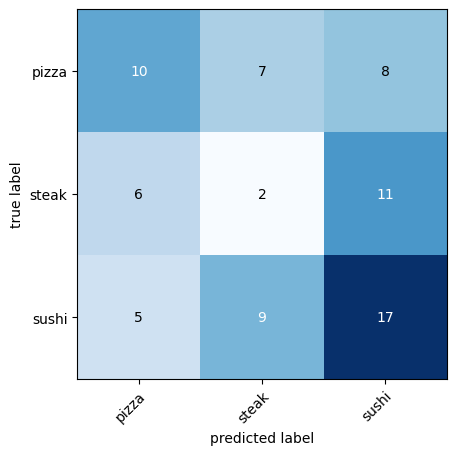

In [17]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_max=ConfusionMatrix(task='multiclass',num_classes=len(class_names))

conf_max_tens=conf_max(preds=liste_pred.to("cpu"),
                       target=liste_true.to("cpu"))


plot_confusion_matrix(conf_max_tens.numpy(),
                      class_names=class_names)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [18]:
from pathlib import Path
from PIL import Image


liste_images_paths=list(image_path.glob("*/*/*.jpg"))
liste_images_paths
liste_totale=[]
for path in liste_images_paths:
    dico_path={}
    vrai_nom=path.parent.stem

    dico_path["path"] = path
    dico_path["label"] = vrai_nom

    image = Image.open(path)
    image=simple_transform(image).unsqueeze(0)

    model_0.eval()
    with torch.inference_mode():
        pred = model_0(image.to(device))
        prob = torch.softmax(pred,dim=1)
        label_pred= class_names[torch.argmax(prob,dim=1)]

        dico_path['prob']=prob.max().item()
        dico_path['predicition']=label_pred
        dico_path["correct"]= vrai_nom == label_pred

    liste_totale.append(dico_path)
        

    

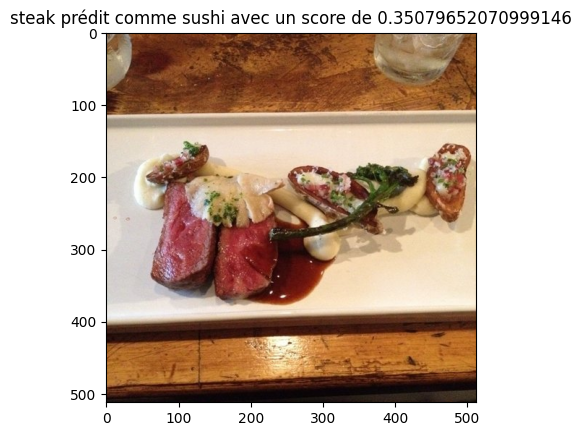

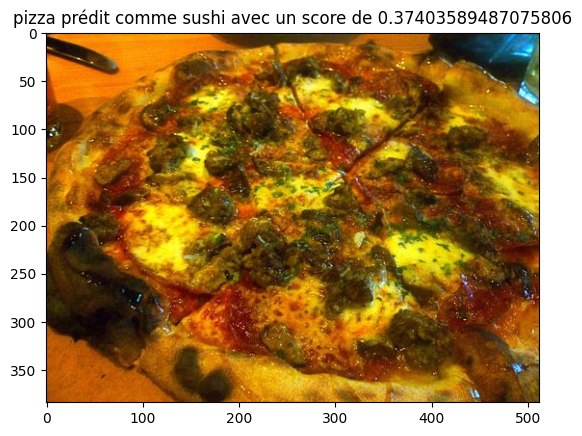

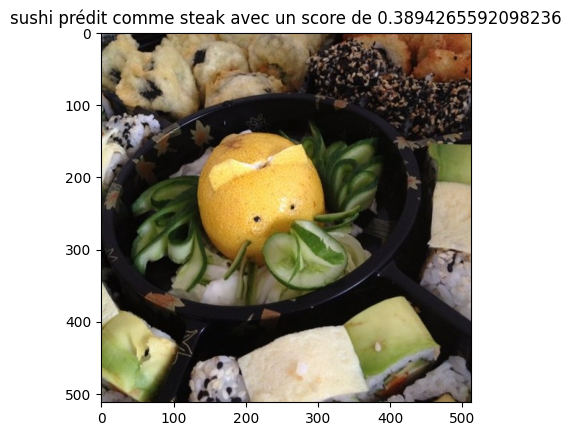

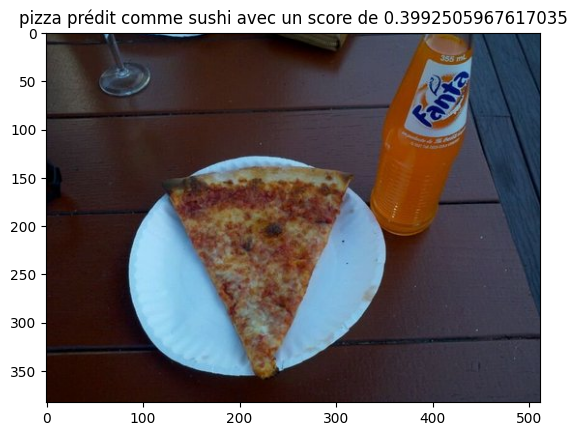

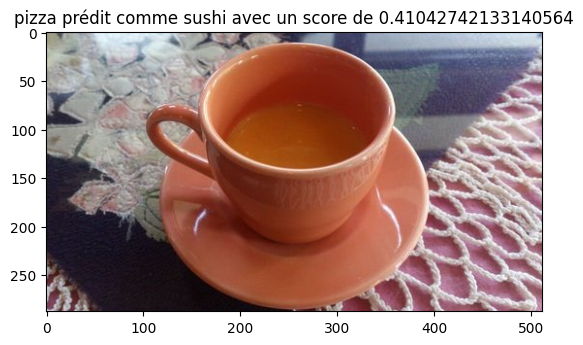

In [19]:
import pandas as pd

df = pd.DataFrame(liste_totale)

df_mauvais = df[df["correct"]==False].sort_values(by="prob")

cinq_mauvais=df_mauvais[0:5]

for raw in cinq_mauvais.iterrows():
    image=Image.open(raw[1][0])
    plt.figure()
    plt.imshow(image)
    plt.title(f"{raw[1][1]} prédit comme {raw[1][3]} avec un score de {raw[1][2]}")



## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'sushi prob de 0.7596104741096497')

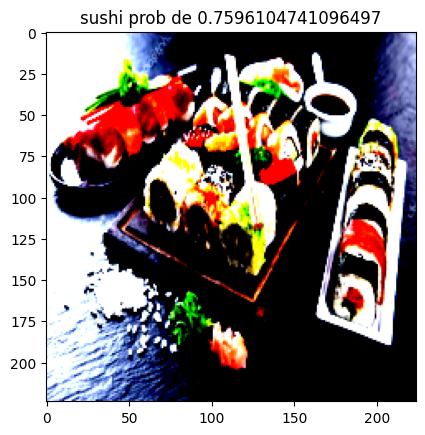

In [20]:
# TODO: Get an image of pizza/steak/sushi
image = Image.open("D:\Adam\Pytorch\exercises\sushi.jpg")
image = simple_transform(image).unsqueeze(0)

pred = model_0(image.to(device))
prob=torch.softmax(pred,dim=1).max().item()
label = torch.argmax(torch.softmax(pred,dim=1),dim=1)

plt.figure()
plt.imshow(image.squeeze(0).permute(1,2,0).detach().cpu().numpy())
plt.title(f"{class_names[label.item()]} prob de {prob}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'steak prob de 0.38556230068206787')

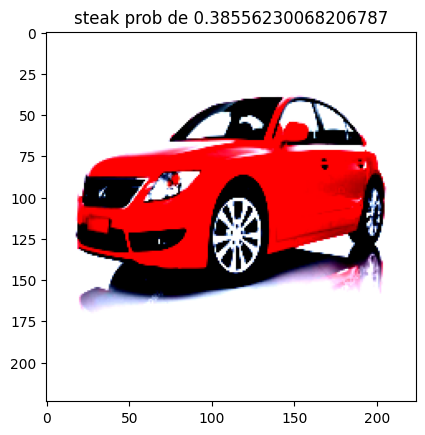

In [21]:
# TODO: Get an image of not pizza/steak/sushi
image = Image.open("D:/Adam/Pytorch/exercises/voiture.jpg")
image = simple_transform(image).unsqueeze(0)

pred = model_0(image.to(device))
prob=torch.softmax(pred,dim=1).max().item()
label = torch.argmax(torch.softmax(pred,dim=1),dim=1)

plt.figure()
plt.imshow(image.squeeze(0).permute(1,2,0).detach().cpu().numpy())
plt.title(f"{class_names[label.item()]} prob de {prob}")

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [22]:
# TODO: Recreate a new model 


In [23]:
# TODO: Train the model for 10 epochs

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [24]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

data\pizza_steak_sushi_20_percent directory exists.


(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [25]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

### Get a pretrained model

In [26]:
import torchvision
from torchinfo import summary


weights= torchvision.models.ResNet101_Weights.DEFAULT
transformer = weights.transforms()


In [27]:
model = torchvision.models.resnet101(pretrained=True).to(device)


for param in model.parameters():
    param.requires_grad=False


model.fc=nn.Sequential(
    nn.Linear(in_features=2048, out_features=3, bias=True)
)

summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size",'output_size','num_params','trainable'],
        row_settings=['var_names'])

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
ResNet (ResNet)                          [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]          [1, 64, 112, 112]         (9,408)                   False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]         [1, 64, 112, 112]         (128)                     False
├─ReLU (relu)                            [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]         [1, 64, 56, 56]           --                        --
├─Sequential (layer1)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --                        False
│    └─Bottleneck (0)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --                        False


In [29]:
from train_modele import train

model_trained= train(model=model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     device=device,
                     optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001),
                     loss_fn=loss_fn,
                     epochs=5
                     )



 20%|██        | 1/5 [00:41<02:47, 41.93s/it]

Epoch: 1 | train_loss: 0.9717 | train_acc: 0.5938 | test_loss: 0.9875 | test_acc: 0.3816


 40%|████      | 2/5 [01:28<02:14, 44.71s/it]

Epoch: 2 | train_loss: 0.8157 | train_acc: 0.6562 | test_loss: 0.6665 | test_acc: 0.6998


 60%|██████    | 3/5 [02:10<01:26, 43.33s/it]

Epoch: 3 | train_loss: 0.7716 | train_acc: 0.5781 | test_loss: 0.4725 | test_acc: 0.9375


 80%|████████  | 4/5 [02:51<00:42, 42.57s/it]

Epoch: 4 | train_loss: 0.7798 | train_acc: 0.5703 | test_loss: 0.4460 | test_acc: 0.9280


100%|██████████| 5/5 [03:33<00:00, 42.74s/it]

Epoch: 5 | train_loss: 0.6172 | train_acc: 0.6758 | test_loss: 0.5840 | test_acc: 0.7538


In [33]:
image = Image.open('sushi.jpg')
image_trans = transformer(image).unsqueeze(0)


pred = model(image_trans.to(device))

label = torch.argmax(torch.softmax(pred,dim=1),dim=1).item()
prob= torch.softmax(pred,dim=1).max().item()
vrai_label = class_names[label]

vrai_label,prob

('sushi', 0.8078315258026123)

### Train a model with 20% of the data

In [ ]:
# TODO

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [ ]:
# TODO 